In [ ]:
# mount google drive on your runtime using and authorization code.
# more details here: https://colab.research.google.com/notebooks/io.ipynb
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import library
import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

import pickle
import os

import cv2
from google.colab.patches import cv2_imshow

from imutils import paths

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# check GPU is available
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

# set random seed of tensorflow
random.seed(1)
np.random.seed(1)
tf.compat.v1.set_random_seed(1)
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1,log_device_placement =True)
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = config)
tf.compat.v1.keras.backend.set_session(sess)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



In [ ]:
# Path to the directory containing the project files (CHANGE THIS PATH TO THE DIRECTORY ON YOUR COMPUTER OR GOOGLE DRIVE)
PROJECT_ROOT_DIR = 'drive/My Drive/CS504(AML)/HW1/BUSI/'

# Path to the directory containing the dataset (DOWNLOAD THE BUSI_DATASET DIRECTORY FROM FOLLOWING LINK)
# DOWNLOAD BUSI dataset here: https://scholar.cu.edu.eg/?q=afahmy/pages/dataset
DATA_DIR = 'Dataset_BUSI_with_GT/'

# Load the BUSI images and labels

In [ ]:
# Funciton for loading the dataset
# reference: https://www.pyimagesearch.com/2018/09/10/keras-tutorial-how-to-get-started-with-keras-deep-learning-and-python/
def load_image():
  # initialize the data and labels for each class
  data = []
  labels = []

  data_aside = []
  labels_aside = []

  benign_data = []
  benign_labels = []

  malignant_data = []
  malignant_labels = []

  normal_data = []
  normal_labels = []

  # load benign image
  for i in range(1,438):
    image = cv2.imread(PROJECT_ROOT_DIR + DATA_DIR + 'benign/' + 'benign (' + str(i) + ').png')
    # resize image to 224 * 224 * 3
    image = cv2.resize(image, (224, 224))
    benign_data.append(image)
    # extract the class label from the image folder
    benign_labels.append('benign')
  # random Select 120 images and set them aside as Adversarial Attack images. These include 60 benign images, 30 malignant images, and 30 normal images
  # select 60 benign images
  random.seed(1)
  random_sample = random.sample(range(len(benign_data)),60)
  for i in range(0,437):
    if i in random_sample:
      data_aside.append(benign_data[i])
      labels_aside.append(benign_labels[i])
    else:
      data.append(benign_data[i])
      labels.append(benign_labels[i])

  # load malignant image
  for i in range(1,211):
    image = cv2.imread(PROJECT_ROOT_DIR + DATA_DIR + 'malignant/' + 'malignant (' + str(i) + ').png')
    # resize image to 224 * 224 * 3
    image = cv2.resize(image, (224, 224))
    malignant_data.append(image)
    # extract the class label from the image folder
    malignant_labels.append('malignant')
  # select 30 malignant images
  random.seed(1)
  random_sample = random.sample(range(len(malignant_data)),30)
  for i in range(0,210):
    if i in random_sample:
      data_aside.append(malignant_data[i])
      labels_aside.append(malignant_labels[i])
    else:
      data.append(malignant_data[i])
      labels.append(malignant_labels[i])
  
  # load normal image
  for i in range(1,134):
    image = cv2.imread(PROJECT_ROOT_DIR + DATA_DIR + 'normal/' + 'normal (' + str(i) + ').png')
    # resize image to 224 * 224 * 3
    image = cv2.resize(image, (224, 224))
    normal_data.append(image)
    # extract the class label from the image folder
    normal_labels.append('normal')
  # select 30 normal images
  random.seed(1)
  random_sample = random.sample(range(len(normal_data)),30)
  for i in range(0,133):
    if i in random_sample:
      data_aside.append(normal_data[i])
      labels_aside.append(normal_labels[i])
    else:
      data.append(normal_data[i])
      labels.append(normal_labels[i])  

  return data, labels, data_aside, labels_aside
# Function for image preprocessing 
def preprocess(data,labels,data_aside, labels_aside):
  # Save training and test image to numpy, Scale image features to be in [0, 1]
  data = np.array(data, dtype = np.float32) / 255.0
  # Save labels to numpy encode label to integer catergory 0 = 'benign', 1 = 'malignant', 2 = 'normal'
  labels = np.array(labels)
  new_label_encoder = preprocessing.LabelEncoder()
  new_label_encoder.fit(labels)
  targets = new_label_encoder.transform(labels)
  # Save aside image to numpy, Scale image features to be in [0, 1]
  data_aside = np.array(data_aside, dtype = np.float32) / 255.0
  # Save labels to numpy encode label to integer catergory 0 = 'benign', 1 = 'malignant', 2 = 'normal' 
  labels_aside = np.array(labels_aside)
  new_labels_aside_encoder = preprocessing.LabelEncoder()
  new_labels_aside_encoder.fit(labels_aside)
  targets2 = new_label_encoder.transform(labels_aside)
  return data, targets, data_aside, targets2

In [ ]:
# Load the BUSI images and labels
data, labels, data_aside, labels_aside = load_image()
data, labels, data_aside, labels_aside = preprocess(data,labels,data_aside, labels_aside)

# split data into 80% train and 20% test, shuffle the data with
(imgs_train, imgs_test, labels_train, labels_test) = train_test_split(data, labels, test_size = 0.2, random_state=42, shuffle = True)
# split data into 60% train data and 20% validation data
(imgs_train, imgs_val, labels_train, labels_val) = train_test_split(imgs_train, labels_train, test_size = 0.2, random_state=42, shuffle = True)

In [ ]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(imgs_train.shape, labels_train.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(imgs_val.shape, labels_val.shape))
print('Images test shape: {} - Labels test shape: {}'.format(imgs_test.shape, labels_test.shape))
print('Aside images shape: {} - Aside Labels shape: {}'.format(data_aside.shape, labels_aside.shape))
# Display the range of images (to make sure they are in the [0, 1] range)
print('\nMax pixel value', np.max(imgs_train))
print('Min pixel value', np.min(imgs_train))
print('Average pixel value', np.mean(imgs_train))
print('Data type', imgs_train[0].dtype)

Images train shape: (422, 224, 224, 3) - Labels train shape: (422,)
Images validation shape: (106, 224, 224, 3) - Labels validation shape: (106,)
Images test shape: (132, 224, 224, 3) - Labels test shape: (132,)
Aside images shape: (120, 224, 224, 3) - Aside Labels shape: (120,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.32330388
Data type float32


In [ ]:
# Set constants (BUSI)
NUM_LABELS = 3                             # Number of labels
BATCH_SIZE = 4                             # Size of batch
HEIGHT = 224                                 # Height of input image
WIDTH = 224                                  # Width of input image
N_CHANNEL = 3                               # Number of channels
OUTPUT_DIM = 3                             # Number of output dimension

# Set training hyperparameters
NUM_EPOCH = 200                             # Number of epoch to train
LR = 0.01                                 # Learning rate

INPUT_SHAPE = (HEIGHT, WIDTH, N_CHANNEL)  # Input shape of model
IMG_SHAPE = (HEIGHT, WIDTH, N_CHANNEL)

In [ ]:
# Convert the labels to one-hot encoding (to input to the models)
labels_train = keras.utils.to_categorical(labels_train, NUM_LABELS)
labels_test = keras.utils.to_categorical(labels_test, NUM_LABELS)
labels_val = keras.utils.to_categorical(labels_val, NUM_LABELS)
labels_aside = keras.utils.to_categorical(labels_aside, NUM_LABELS)
print('Labels train shape: {}'.format(labels_train.shape))

Labels train shape: (422, 3)


# Create and train model by using TensorFlow with Keras API

In [ ]:
# load ResNet50 model with imagenet pretrained in Keras API (NOT INCLUDE TOP DENSE LAYERS)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=keras.layers.Input((224,224,3)))
# Fine-tune ResNet50 model.
# Add several Dense layers on top of it and a softmax dense layer with output dense of 3 labels
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
predictions = keras.layers.Dense(NUM_LABELS, activation='softmax')(x)
model = keras.Model(inputs=[base_model.input], outputs=[predictions])

In [ ]:
# SGD optimizer
optimizer = keras.optimizers.SGD(learning_rate=LR)
# early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
# reduce lr based on val_loss
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)
# compile the keras model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

# fit the keras model on the dataset with validation for monitoring validation loss and accuracy at the end of each epoch
history = model.fit(imgs_train, labels_train, epochs = NUM_EPOCH, batch_size = BATCH_SIZE, validation_data = (imgs_val, labels_val), shuffle = True, callbacks=[callback,reduce_lr])

Epoch 1/200
106/106 [==============================] - 16s 89ms/step - loss: 1.0287 - accuracy: 0.5237 - val_loss: 1.9881 - val_accuracy: 0.2358
Epoch 2/200
106/106 [==============================] - 8s 72ms/step - loss: 0.6638 - accuracy: 0.7227 - val_loss: 2.4286 - val_accuracy: 0.2358
Epoch 3/200
106/106 [==============================] - 8s 72ms/step - loss: 0.5061 - accuracy: 0.7938 - val_loss: 1.9432 - val_accuracy: 0.1604
Epoch 4/200
106/106 [==============================] - 8s 72ms/step - loss: 0.3843 - accuracy: 0.8626 - val_loss: 2.4785 - val_accuracy: 0.2358
Epoch 5/200
106/106 [==============================] - 8s 72ms/step - loss: 0.2608 - accuracy: 0.8957 - val_loss: 2.4069 - val_accuracy: 0.2358
Epoch 6/200
106/106 [==============================] - 8s 72ms/step - loss: 0.1972 - accuracy: 0.9384 - val_loss: 1.8980 - val_accuracy: 0.2358
Epoch 7/200
106/106 [==============================] - 8s 72ms/step - loss: 0.1466 - accuracy: 0.9621 - val_loss: 1.4571 - val_accuracy

In [ ]:
# evaluate the keras model with test images and aside images
results = model.evaluate(imgs_test, labels_test)
print("test loss, test acc:", results)
results = model.evaluate(data_aside, labels_aside)
print("aside test loss, aside test acc:", results)

5/5 [==============================] - 1s 79ms/step - loss: 0.6928 - accuracy: 0.8485
test loss, test acc: [0.6928045153617859, 0.8484848737716675]
4/4 [==============================] - 1s 294ms/step - loss: 0.9014 - accuracy: 0.8500
aside test loss, aside test acc: [0.9014062881469727, 0.8500000238418579]


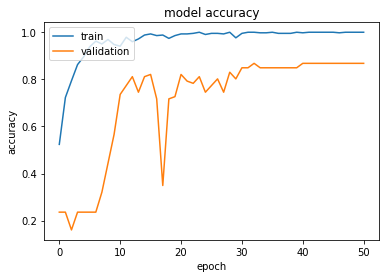

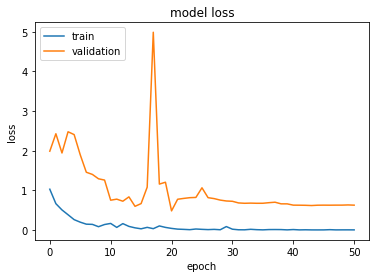

In [ ]:
#  Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# save model
model_save_path = PROJECT_ROOT_DIR + 'BUSI_dataset_resnet50.h5'
model.save(model_save_path)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
